# Approach 2: LIME

Local Interpretable Model-agnostic Explanations (LIME) is one of the most popular Explainable AI (XAI) methods used for explaining the working of machine learning and deep learning models. Lime is model-agnostic, so it can be applied to any machine learning model. The algorithm highlights the superpixels in images that contribute positively or negatively to the model’s decision-making process. Superpixels are compact image fragments that are uniform in size and adhere well to area boundaries.

# How does it work?
We choose a sample that we want to explain (x). LIME generates a new dataset consisting of perturbed samples of x (bold red cross) and the corresponding predictions. Then these perturbed samples are fed into the model to see how it would predict them.
![image info](https://raw.githubusercontent.com/marcotcr/lime/master/doc/images/lime.png)
The models (ResNet50) complex decision function (blue/white background) is unknown to LIME and cannot be approximated well by a linear model.
 Since one of the premises on which LIME is built is that the interpretable model can be a good local approximation, we are mainly interested in the perturbed samples that are close to x. To learn the interpretable model, LIME weights the samples according to their proximity to x, so that samples that are close to x get a high weight and samples that are far from x get a low weight (weight indicated by size). The default interpretable model used by LIME is a linear model (dashed line). It is learned from the weighted samples and provides explanations for a particular prediction, in this case x.

# Sources
Explanations:
 https://www.openlayer.com/blog/post/understanding-lime-in-5-steps
 https://towardsdatascience.com/how-to-explain-image-classifiers-using-lime-e364097335b4
 https://github.com/marcotcr/lime

Ribeiro, M. T., Singh, S., & Guestrin, C. (2016, August). " Why should i trust you?" Explaining the predictions of any classifier. In Proceedings of the 22nd ACM SIGKDD international conference on knowledge discovery and data mining (pp. 1135-1144).

Code:
https://towardsdatascience.com/how-to-explain-image-classifiers-using-lime-e364097335b4
https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb



In [4]:
import numpy as np
import pandas as pd

from torchvision import *
import torch.nn as nn
import torch
import torch.nn.functional as F
import os

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from lime import lime_image
from skimage.segmentation import mark_boundaries

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = models.resnet50(pretrained=True)
net = net.to(device)

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 6)
net.fc = net.fc.to(device)

net.load_state_dict(torch.load(os.path.join('model','landscape_resnet.pt'), map_location=torch.device(device)))

net.eval

In [3]:
X_test = torch.load(os.path.join('data', 'X_test.pt'))
print(X_test.shape)

y_test = torch.load(os.path.join('data', 'y_test.pt'))
print(y_test.shape)

predictions = np.array(pd.read_csv('predictions.csv')['46'])
print(predictions.shape)

(2993, 150, 150, 3)
(2993,)
(2993,)


In [ ]:
correct_imgs = [317, 2000, 2505, 477, 950, 1479]
wrong_imgs = [30, 86, 1518]

In [3]:
def decode_label(ind):
    
    label_dict = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
    decode_dict = {v: k for k, v in label_dict.items()}
    
    return decode_dict[ind]

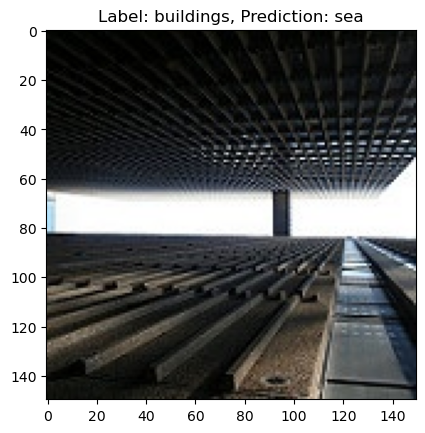

In [6]:
ind = 30  #specify index of image to analyse this image

img = X_test[ind]
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img = Image.fromarray(img)

label = decode_label(y_test[ind])
prediction = decode_label(predictions[ind])

plt.imshow(img)
plt.title(f'Label: {label}, Prediction: {prediction}')
plt.show()

In [7]:
def get_pil_transform(): 
    transf = transforms.Compose([
          transforms.Resize(224)              
          ])

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize([115.70155906, 116.65272372, 109.69618953], [76.06980096, 68.32058804, 68.69814773])    
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [8]:
def batch_predict(images):
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    batch = batch.to(device)
    
    logits = net(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [9]:
explainer = lime_image.LimeImageExplainer()
exp = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.64it/s]


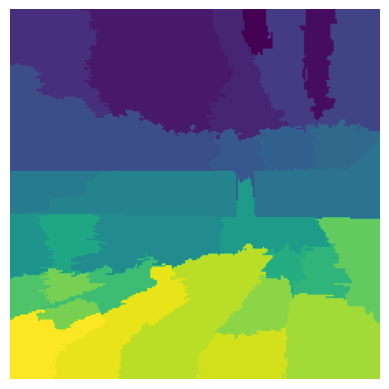

In [10]:
# visualize the explanation segments created by the LIME algorithm
plt.imshow(exp.segments)
plt.axis('off')
plt.show()

In [11]:
def generate_prediction_sample(exp, exp_class, weight = 0.01, show_positive = True, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    image, mask = exp.get_image_and_mask(exp_class, 
                                         positive_only=show_positive, 
                                         num_features=6, 
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    plt.imshow(mark_boundaries(image, mask))
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


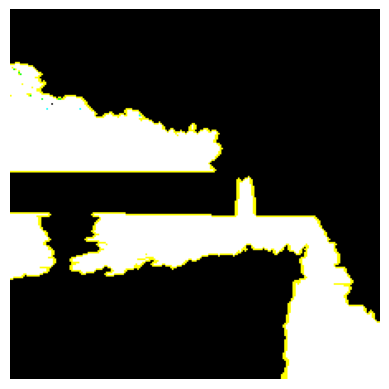

In [12]:
#identify the region of interest of the image used by the model to make its prediction
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = True)

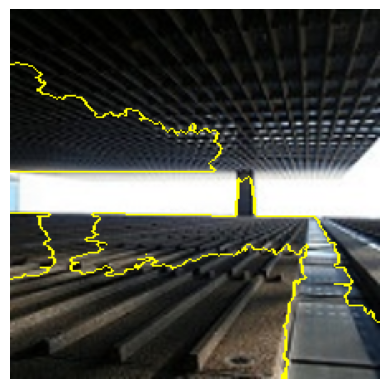

In [13]:
#highlight the contour of the superpixel and include the background as well
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = False)

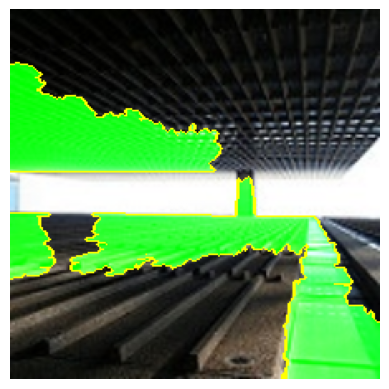

In [14]:
#highlight the positive super-pixels
generate_prediction_sample(exp, exp.top_labels[0], show_positive = False, hide_background = False)

In [15]:
def explanation_heatmap(exp, exp_class):
    '''
    Using heat-map to highlight the importance of each super-pixel for the model prediction
    '''
    dict_heatmap = dict(exp.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments) 
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.show()

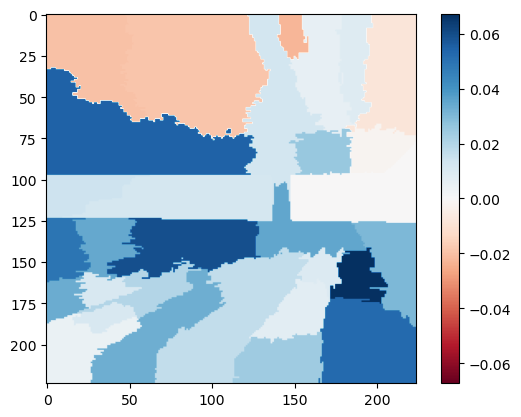

In [16]:
#get heat-map to show how important each super-pixel is
explanation_heatmap(exp, exp.top_labels[0])